# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import env
import loader_utils
import waymo_loader
import pickle
import os
import lzma
import numpy as np
import random
import gymnasium as gym
import typing
from metadrive import MetaDriveEnv

from env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from metadrive_model import MetadriveModel
from model_utils import set_lr, deviceof

# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

2023-08-26 14:19:34.377061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 14:19:35.494016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
file_iter = iter(loader_utils.getFiles(WAYMO_DATA_PATH))
trajectories: list[list[State]] = []

In [34]:
for file_path in file_iter:
    trajectories_in_file = waymo_loader.parse_file(file_path)
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}.")

Loaded 88 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00040-of-01000.
Loaded 68 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00041-of-01000.


KeyboardInterrupt: 

In [36]:
# pickle the trajectories
if not os.path.exists('./data/waymo/trajectories.pkl.xz'):
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [2]:
# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'rb') as f:
        trajectories: list[list[State]] = pickle.load(f)

In [3]:
idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [4]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 419886
validation data: 46654


In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
mm = MetadriveModel().to(device)
mm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 768, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx4x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [8]:
import itertools

idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [81]:
set_lr(idm_optimizer, 3e-5)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 10000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 4096

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 500 == 0:
        # print average loss over last 500 steps
        loss = np.mean(idm_losses[-500:])
        print(f"Step: {idm_step}, Loss: {loss:.5f}")

Step: 6500, Loss: 0.00071
Step: 7000, Loss: 0.00068
Step: 7500, Loss: 0.00068
Step: 8000, Loss: 0.00067
Step: 8500, Loss: 0.00064
Step: 9000, Loss: 0.00065
Step: 9500, Loss: 0.00066
Step: 10000, Loss: 0.00060


In [9]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('waymo_data/idm.pth'))    

In [103]:
# save idm
if not os.path.exists('./data/waymo/idm.pth'):
    torch.save(idm.state_dict(), './data/waymo/idm.pth')

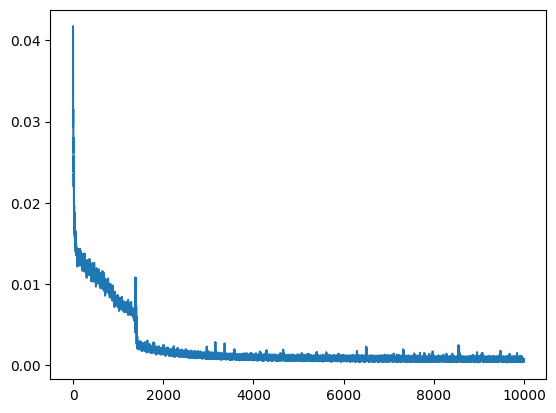

In [82]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

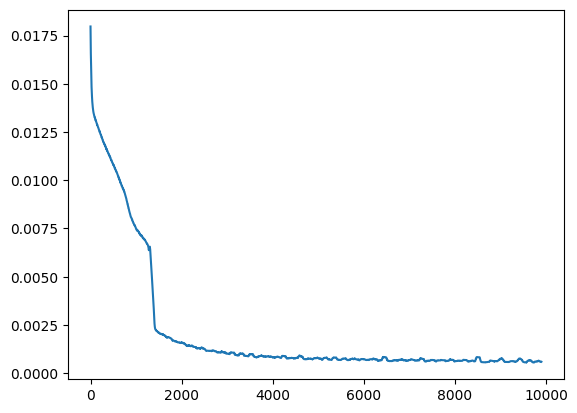

In [83]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((100,))/100, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [10]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.05040532723069191


In [85]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.0005255897995084524


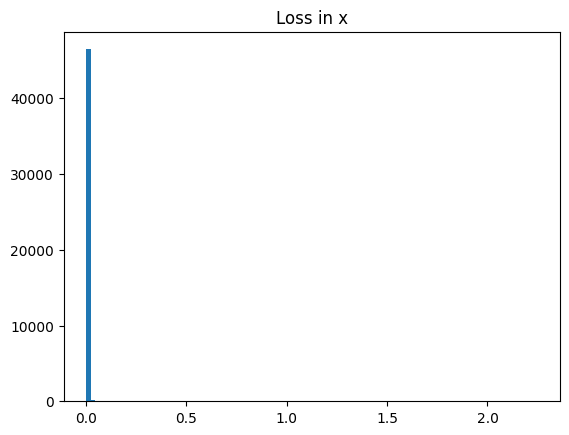

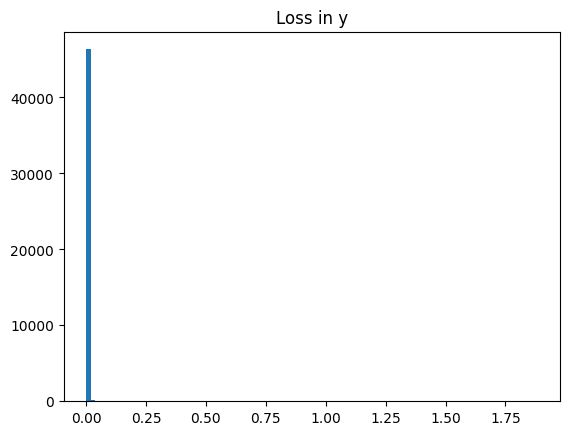

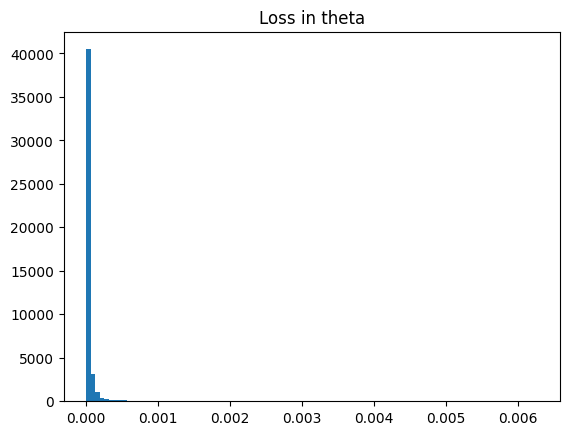

In [86]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


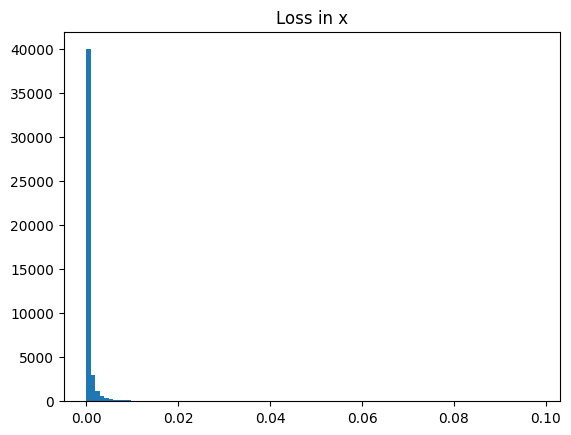

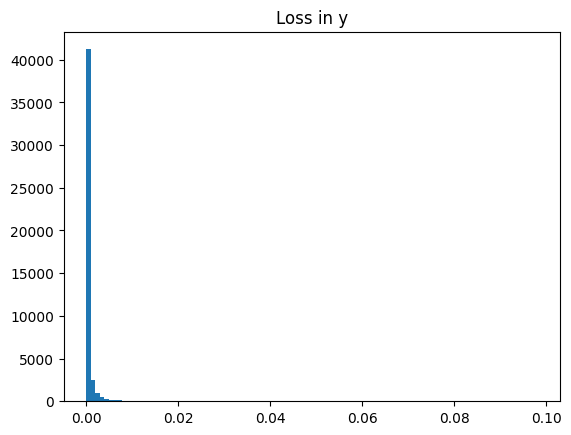

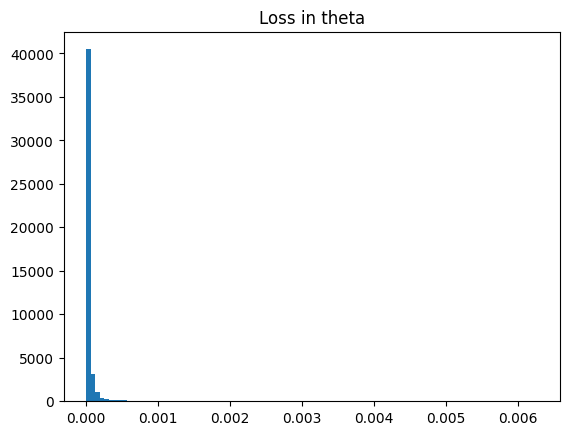

In [87]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [88]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [89]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: [dashboard: VehiclePanel(), main_camera: MainCamera(1200, 900)]
[INFO] Render Mode: onscreen


### Trajectory Replay

In [90]:
scenario = trajectories[7]

# reset
env.reset()

# allow car to settle
for _ in range(10):
    env.step([0,0])

# set the initial state
for i in range(len(scenario)):
    st = scenario[i]
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])        

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
[INFO] Assets version: 0.4.1.2


Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event17 is not readable, some features will be unavailable.
:device(warning): /dev/input/event19 is not readable, some features will be unavailable.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: 

### Closed Loop IDM

In [50]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(0.03474266082048416, -0.016190748661756516)
[-0.00226374  0.00010625] 3.139901146823429 [ 0.00043602 -0.00024465] 3.1399006843566895
(0.03492933139204979, -0.018615908920764923)
[3.79380421e-03 8.27628173e-06] 3.1399008805073203 [ 8.5138498e-05 -2.9869622e-04] 3.1399006843566895
(0.034499652683734894, -0.008971190080046654)
[-1.85657264e-04 -3.68001129e-05] 3.139901146823429 [-0.00052166  0.00038377] 3.1399006843566895
(0.03462446108460426, -0.016400868073105812)
[3.45229753e-03 2.93358298e-05] 3.139901279981484 [0.00046527 0.00013036] 3.1399006843566895
(0.03484826907515526, -0.011420400813221931)
[-2.39919825e-03 -2.26599404e-05] 3.139901546297593 [ 0.0003895  -0.00043005] 3.1399002075195312
(0.035169605165719986, -0.017464693635702133)
[3.28170578e-03 3.90288769e-05] 3.139901546297593 [-0.00062505 -0.00058191] 3.1399011611938477
(0.03519551083445549, -0.007598198018968105)
[1.04414625e-03 1.41089222e-05] 3.139901279981484 [-0.00170801 -0.00066388] 3.1399011611938477
(0.035183023661

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004610867239534855, 0.7103093862533569)
[-4.47436619e+00  1.95944170e-03] -3.1403802495035347 [-4.5551896   0.01617766] 3.1389429569244385


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001988697098568082, 0.6989791989326477)
[-4.66739941e+00  6.83440652e-04] -3.140833519521066 [-4.7466025   0.01397061] 3.139603853225708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007596839219331741, 0.6903386116027832)
[-4.85795021 -0.0148687 ] -3.1408400442657367 [-4.936439e+00 -2.037717e-03] 3.140251874923706


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0035132032353430986, 0.68465256690979)
[-5.04700375e+00 -2.58819293e-03] -3.1404625411812184 [-5.1239367   0.00529932] 3.1406409740448


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008305681403726339, 0.6729461550712585)
[-5.23283863 -0.00603203] -3.140560012877115 [-5.3084793e+00  2.8328467e-03] 3.1415035724639893


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0064254021272063255, 0.6583934426307678)
[-5.41459846 -0.01812943] -3.140301020461105 [-5.485771   -0.01084067] -3.1406049728393555


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013733555097132921, 0.6292207837104797)
[-5.58837128 -0.00958237] -3.1398112651366388 [-5.653316   -0.00685943] -3.140117645263672


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00013392535038292408, 0.6089295148849487)
[-5.75654221 -0.00988115] -3.139779573519667 [-5.8174229e+00 -3.6494776e-03] -3.140202760696411


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003334570908918977, 0.6020753383636475)
[-5.92281055e+00 -3.29596759e-03] -3.139917525264133 [-5.9813228e+00  1.3929437e-03] -3.140294313430786


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002005568938329816, 0.5772967338562012)
[-6.08224583e+00 -2.68554315e-03] -3.1403027515158133 [-6.1347036e+00  1.4261095e-03] -3.1398184299468994


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0016762136947363615, 0.5526764988899231)
[-6.23486519 -0.00932857] -3.140505551232823 [-6.2816114  -0.00709968] -3.139355182647705


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001705211354419589, 0.54264897108078)
[-6.38471985 -0.01211409] -3.140348424728508 [-6.4288983  -0.01215883] -3.1391754150390625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002493207575753331, 0.5331613421440125)
[-6.53195381e+00 -4.32377728e-03] -3.1402645351541705 [-6.5740957e+00 -6.5437974e-03] -3.1390678882598877


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010367489885538816, 0.5181905031204224)
[-6.67505169 -0.00918074] -3.140412606910779 [-6.713228   -0.00961267] -3.1382884979248047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004919678904116154, 0.4853062331676483)
[-6.80902576 -0.02080715] -3.1401391002668277 [-6.8402     -0.02250789] -3.1377005577087402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0004426098894327879, 0.4635528028011322)
[-6.93705559 -0.0168392 ] -3.139591421188653 [-6.9642324  -0.02165782] -3.1377060413360596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0027984946500509977, 0.4421353042125702)
[-7.05913258 -0.02305355] -3.139262920268192 [-7.0821667  -0.02635546] -3.1370458602905273


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0030349947046488523, 0.39307838678359985)
[-7.16766834 -0.02813687] -3.138765042302402 [-7.181623   -0.03506013] -3.1363561153411865


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0020317297894507647, 0.35363689064979553)
[-7.26534653 -0.01944729] -3.138434144536959 [-7.272405   -0.03029917] -3.1362617015838623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0018697225023061037, 0.3509697914123535)
[-7.36227751 -0.01655978] -3.1386337484606606 [-7.3691273  -0.02843684] -3.136166572570801


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(1.69284176081419e-05, 0.32394304871559143)
[-7.45173502 -0.01937586] -3.1388767619101303 [-7.4534125  -0.03498147] -3.1358821392059326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00023323413915932178, 0.29730382561683655)
[-7.53383684 -0.01927769] -3.1389542598978517 [-7.530382   -0.03912928] -3.1355092525482178


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005133759696036577, 0.2952723801136017)
[-7.61538744 -0.01830363] -3.139023502086194 [-7.6117287  -0.04031157] -3.1349258422851562


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0034175037872046232, 0.2531612515449524)
[-7.68524981 -0.02872276] -3.138917907748972 [-7.673127   -0.05354911] -3.1342294216156006


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007228024769574404, 0.20791448652744293)
[-7.74268484 -0.02300687] -3.1385732947039156 [-7.721699   -0.04993875] -3.134127140045166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001080033602192998, 0.18660038709640503)
[-7.79422712 -0.02040623] -3.138607250007814 [-7.7687907  -0.04504098] -3.1339662075042725


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0019740413408726454, 0.16526666283607483)
[-7.8398385  -0.02757916] -3.138628688454589 [-7.809274   -0.05363196] -3.133704662322998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007833826821297407, 0.1851481795310974)
[-7.89097309 -0.02799087] -3.138386473953447 [-7.8650556  -0.05483527] -3.1335628032684326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002352951793000102, 0.2081167995929718)
[-7.94842339 -0.0340842 ] -3.138108040461479 [-7.9272394  -0.06101742] -3.1332848072052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002870765281841159, 0.16884000599384308)
[-7.99501705 -0.03999209] -3.1376268072525013 [-7.9653306  -0.06778286] -3.1328823566436768


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008900549728423357, 0.12518931925296783)
[-8.02961826 -0.03395166] -3.1372341241497694 [-7.9913125  -0.05963857] -3.132650852203369


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005537557881325483, 0.0928652286529541)
[-8.05526066 -0.0364646 ] -3.1371923125206553 [-8.009397   -0.06108648] -3.1321752071380615


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0051587289199233055, 0.06581753492355347)
[-8.07331181 -0.05162572] -3.1368441042081274 [-8.020257   -0.07973618] -3.1319282054901123


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0017234075348824263, 0.07817547023296356)
[-8.09490871 -0.0510549 ] -3.136094956993488 [-8.045578   -0.07907796] -3.1319661140441895


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0015083893667906523, 0.09895722568035126)
[-8.12223148 -0.05333706] -3.135616786419764 [-8.077525  -0.0790439] -3.131410837173462


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002755180699750781, 0.09572844207286835)
[-8.14861584 -0.05999161] -3.135173902730484 [-8.102883  -0.0859643] -3.131118059158325


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000299281207844615, 0.07832668721675873)
[-8.17026234 -0.05783338] -3.134736345363384 [-8.121379   -0.08270792] -3.1312150955200195


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006238825153559446, 0.04694318398833275)
[-8.18322277 -0.05941115] -3.134548858822643 [-8.127264   -0.08314626] -3.130937337875366


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013555909972637892, 0.032219450920820236)
[-8.19208431 -0.0629853 ] -3.134357244382211 [-8.132165   -0.08751381] -3.1305618286132812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004973143804818392, 0.03709836304187775)
[-8.20234394 -0.06003419] -3.134184138911356 [-8.144417   -0.08385364] -3.130368709564209


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0015320542734116316, 0.02309606596827507)
[-8.20867062 -0.06535329] -3.1341065077655808 [-8.14503    -0.08968093] -3.1298043727874756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002550354925915599, 0.003139384090900421)
[-8.20947361 -0.07141275] -3.1337762757904106 [-8.13582    -0.09758261] -3.129906415939331


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015926577616482973, -0.01158136036247015)
[-8.19068432 -0.0632722 ] -3.1334917170279355 [-8.124469   -0.08827388] -3.1297264099121094


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0014202080201357603, -0.02250891923904419)
[-8.15400982 -0.06890063] -3.1335095602072394 [-8.093615   -0.09341777] -3.129460573196411


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002298270119354129, -0.02175324410200119)
[-8.11857319 -0.07420944] -3.1332364530374512 [-8.057619   -0.10009596] -3.129662036895752


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011696286965161562, -0.03866876661777496)
[-8.05571461 -0.06747935] -3.132973199563697 [-8.006659  -0.0920931] -3.129572629928589


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001706405309960246, -0.026234600692987442)
[-8.01298046 -0.0733367 ] -3.1329337847795635 [-7.955096   -0.09689596] -3.1293883323669434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00029282900504767895, -0.018617641180753708)
[-7.98270607 -0.07208779] -3.132726590846756 [-7.9208517  -0.09604318] -3.1292858123779297


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000400792108848691, -0.04766630381345749)
[-7.90518665 -0.06977943] -3.132658280764795 [-7.8615403  -0.09291332] -3.1288952827453613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0018957096617668867, -0.04258892685174942)
[-7.83585072 -0.07512619] -3.1325821143576187 [-7.7884064  -0.09823551] -3.1287920475006104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010305836331099272, -0.020640306174755096)
[-7.80227184 -0.07575247] -3.1323079419233952 [-7.7417846  -0.09881878] -3.1287028789520264


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0015166706871241331, -0.023126380518078804)
[-7.76462841 -0.07838994] -3.1320434900271508 [-7.7055836  -0.10083608] -3.1284127235412598


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013752828817814589, -0.044110313057899475)
[-7.69286156 -0.07974332] -3.1317414875595357 [-7.647331   -0.10284723] -3.1281168460845947


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000851507531479001, -0.03370562940835953)
[-7.63807297 -0.07509512] -3.131561191553737 [-7.587268   -0.09734943] -3.1282951831817627


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014398873317986727, -0.03232990950345993)
[-7.58551598 -0.07137161] -3.1316733106356294 [-7.534224   -0.09294425] -3.128384590148926


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010580264497548342, -0.03797105699777603)
[-7.52376461 -0.06970565] -3.1319074024954476 [-7.4762063  -0.09190903] -3.128476619720459


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009196188766509295, -0.03656821697950363)
[-7.46429253 -0.06802896] -3.1321261811789975 [-7.416201   -0.09116205] -3.128678560256958


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006430328357964754, -0.03727373480796814)
[-7.40367222 -0.06685281] -3.1323104719264308 [-7.356275   -0.09056676] -3.1285853385925293


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000260448781773448, -0.04193531349301338)
[-7.33545113 -0.06772372] -3.132410606783418 [-7.2912035  -0.09142495] -3.128488540649414


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000961345387622714, -0.0631549209356308)
[-7.23270798 -0.06909379] -3.1323644009385054 [-7.2026224  -0.09289464] -3.128486156463623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001422657398506999, -0.07629615068435669)
[-7.10857964 -0.07050444] -3.1321879665162875 [-7.0878816  -0.09289689] -3.128194570541382


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0021261710207909346, -0.04839817434549332)
[-7.02981663 -0.07347447] -3.1319019430152126 [-6.992292   -0.09141897] -3.1282029151916504


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009781394619494677, -0.03346996009349823)
[-6.97542667 -0.06787446] -3.1316677179973404 [-6.929097   -0.08386412] -3.1283011436462402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(5.277572199702263e-06, -0.05282234773039818)
[-6.88950062 -0.06783725] -3.131695281714623 [-6.8567486  -0.08160892] -3.128199815750122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0027140032034367323, -0.05714765936136246)
[-6.79646206 -0.07384048] -3.1315794342072043 [-6.766413   -0.08514406] -3.128192901611328


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006818945985287428, -0.056117285043001175)
[-6.70519829 -0.07170132] -3.131268243833828 [-6.675571   -0.08168306] -3.1281826496124268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010063822846859694, -0.05107812583446503)
[-6.62210369 -0.07212781] -3.1310739662323073 [-6.589688   -0.07862984] -3.127986192703247


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005113094113767147, -0.04504955932497978)
[-6.54867411 -0.08233319] -3.130704852105222 [-6.5118413  -0.08559593] -3.1279919147491455


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.5930031016469e-05, -0.031116049736738205)
[-6.49812651 -0.07603242] -3.1301561077626117 [-6.451057   -0.08096394] -3.128377914428711


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002450767206028104, -0.03949260711669922)
[-6.43394899 -0.06881876] -3.1301166929784783 [-6.394011   -0.07242498] -3.1280903816223145


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004874628968536854, -0.04094385355710983)
[-6.36714172 -0.08209398] -3.1301112334982433 [-6.3292084  -0.08215474] -3.1277029514312744


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010346814524382353, -0.035251762717962265)
[-6.30983639 -0.07904425] -3.12965050662966 [-6.2688785  -0.08159854] -3.1278867721557617


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0002579155843704939, -0.03212471306324005)
[-6.25759983 -0.07722151] -3.1294208089856403 [-6.2156696  -0.07818554] -3.127986431121826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005007951986044645, -0.04032866656780243)
[-6.19199657 -0.07701205] -3.1293165462289636 [-6.157755   -0.07686767] -3.1277849674224854


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011008426081389189, -0.029489148408174515)
[-6.14401054 -0.0783816 ] -3.1292013645118177 [-6.1027284  -0.07814575] -3.127502202987671


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0035800382029265165, -0.030231231823563576)
[-6.09473658 -0.08454467] -3.1289302547128477 [-6.055022   -0.08278003] -3.1277928352355957


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0032446517143398523, -0.019604798406362534)
[-6.06295872 -0.07321065] -3.1286957633788663 [-6.0161633  -0.07310461] -3.127702236175537


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0034037462901324034, -0.017238179221749306)
[-6.03476429 -0.08294583] -3.128754619238957 [-5.986308   -0.07921196] -3.1275134086608887


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001952022546902299, -0.01667921245098114)
[-6.00771618 -0.07530725] -3.1285781848167393 [-5.9596243  -0.07420113] -3.127591133117676


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009004048071801662, -0.028842423111200333)
[-5.96091652 -0.05697773] -3.1290479664330295 [-5.9232383  -0.05684425] -3.1278772354125977


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003719857195392251, -0.00815529003739357)
[-5.94764376 -0.05820516] -3.130050912899553 [-5.89434    -0.05387398] -3.128659725189209


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01406839955598116, -0.009253285825252533)
[-5.93262911 -0.03347756] -3.1311951400619056 [-5.8795786  -0.03295749] -3.1304931640625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.026254119351506233, 0.008793402463197708)
[-5.93472052  0.00773566] -3.1336858614714025 [-5.8737516   0.00843183] -3.1334664821624756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03363944962620735, 0.028064660727977753)
[-5.9418416   0.05112264] -3.1378246801214944 [-5.8880157   0.05388897] -3.1375889778137207


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.038720544427633286, 0.04482245817780495)
[-5.95330048  0.09573799] 3.139965994795973 [-5.9053335   0.09981886] 3.1403164863586426


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.049297820776700974, 0.05639266595244408)
[-5.96683645  0.15687406] 3.1333865221648773 [-5.922057    0.15948884] 3.1328275203704834


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.06451846659183502, 0.062257032841444016)
[-5.97986221  0.23987573] 3.125007551585216 [-5.9366837  0.2415988] 3.122936964035034


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08983053267002106, 0.08371961116790771)
[-5.99370718  0.36169145] 3.1138618229490707 [-5.955707   0.3590463] 3.1113383769989014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08647844195365906, 0.09326328337192535)
[-6.01279354  0.44933337] 3.1000117873840045 [-5.9803863   0.45481652] 3.0980918407440186


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.10172949731349945, 0.09678950905799866)
[-6.02703619  0.57031608] 3.085016725708259 [-5.9904094   0.57558185] 3.0816097259521484


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12101250886917114, 0.09976089000701904)
[-6.03502989  0.71889526] 3.0676505185559613 [-5.992783   0.7350989] 3.0628116130828857


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12602049112319946, 0.11322954297065735)
[-6.04573917  0.85921037] 3.0477866657753325 [-6.0055723  0.8893352] 3.0420024394989014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.13880817592144012, 0.12019217014312744)
[-6.05052137  1.02122414] 3.0262226509547974 [-6.0060816  1.0553811] 3.0191872119903564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1530151069164276, 0.10534924268722534)
[-6.04249763  1.20070541] 3.002482700365613 [-5.9867115  1.2304814] 2.993788480758667


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.181748628616333, 0.10640805959701538)
[-6.01426935  1.42738652] 2.9757014198115583 [-5.9556746  1.4381461] 2.9664740562438965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1691974550485611, 0.0777701735496521)
[-5.99235344  1.59578729] 2.9461535143590742 [-5.91802    1.6194694] 2.9379968643188477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.17035534977912903, 0.6749875545501709)
[-6.1192522   1.82167065] 2.916630642620838 [-6.164891   1.9156319] 2.9071273803710938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2097500115633011, 0.3444848656654358)
[-6.10986471  2.11815834] 2.8847551343756246 [-6.108962  2.1561  ] 2.870506525039673


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2233155220746994, -0.1287667602300644)
[-5.80914068  2.30069709] 2.848275286921774 [-5.7415304  2.291055 ] 2.83601713180542


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.22475948929786682, 0.0810338705778122)
[-5.72836447  2.5360806 ] 2.810100470592142 [-5.639529   2.5311344] 2.7999062538146973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2219190150499344, 0.06605266034603119)
[-5.64050388  2.75783706] 2.7712781066434573 [-5.5432763  2.7456276] 2.7616446018218994


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.23502212762832642, 0.05857806280255318)
[-5.52259302  3.00382829] 2.731854800394797 [-5.431859   2.9696383] 2.721949338912964


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.23918667435646057, 0.06112842634320259)
[-5.39716387  3.24298644] 2.690979139245661 [-5.3053503  3.2086647] 2.682621479034424


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.22846299409866333, 0.0591968335211277)
[-5.28183031  3.4523046 ] 2.64977870560159 [-5.1874456  3.4249787] 2.6420557498931885


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25134769082069397, 0.07888275384902954)
[-5.11746502  3.7092967 ] 2.608378734612845 [-5.0449705  3.6606538] 2.5991098880767822


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25564613938331604, 0.06560264527797699)
[-4.94751024  3.94832516] 2.5647594183296825 [-4.871874   3.8999128] 2.5557849407196045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.24471332132816315, 0.06414543092250824)
[-4.79190683  4.1572628 ] 2.520554206606702 [-4.708839  4.111925] 2.512826442718506


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2518855631351471, 0.11481809616088867)
[-4.61568165  4.38716316] 2.476736018769138 [-4.5531497  4.3318195] 2.469095468521118


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25716033577919006, 0.164998859167099)
[-4.43178415  4.6244154 ] 2.432057763057533 [-4.382289  4.564064] 2.4246909618377686


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25975918769836426, 0.17552217841148376)
[-4.23677588  4.85738468] 2.386375362456913 [-4.1933804  4.7883058] 2.3797221183776855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2648775279521942, 0.7772904634475708)
[-4.1229744   5.21752405] 2.339561251551064 [-4.1896744  5.269367 ] 2.3345541954040527


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2500995397567749, 0.43508556485176086)
[-3.96163726  5.48457861] 2.2916400645800694 [-3.9815044  5.4828253] 2.284788131713867


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2636997699737549, -0.06632164120674133)
[-3.61083627  5.58117485] 2.2438924491331207 [-3.5612056  5.4342976] 2.239339828491211


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.24002565443515778, 0.06632642447948456)
[-3.39230967  5.73651981] 2.1966012994970114 [-3.344725   5.6288614] 2.1936025619506836


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.243977352976799, 0.11857762932777405)
[-3.13957119  5.90809298] 2.1511681041953956 [-3.116424  5.810267] 2.1483497619628906


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.21812106668949127, 0.13583612442016602)
[-2.94207454  6.05092764] 2.106881333164032 [-2.9005613  5.977786 ] 2.104431629180908


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.22098009288311005, 0.18975238502025604)
[-2.70799899  6.21084118] 2.0649235630849696 [-2.6915052  6.149681 ] 2.061194658279419


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.22614766657352448, 0.24977727234363556)
[-2.45616579  6.38070869] 2.0229279095394013 [-2.446742  6.338473] 2.018435478210449


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2014174908399582, 0.2624348998069763)
[-2.26228023  6.52865028] 1.981303400781249 [-2.2303321  6.4948745] 1.9768139123916626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1989627331495285, 0.2595067024230957)
[-2.03780484  6.67350054] 1.941878563214961 [-2.016091   6.6281304] 1.9360601902008057


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1935327649116516, 0.27680256962776184)
[-1.81178439  6.81387329] 1.9032945521838387 [-1.7863135  6.766752 ] 1.8969391584396362


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.17317233979701996, 0.2980300486087799)
[-1.6231904   6.94577026] 1.8661231483739213 [-1.5823803  6.907919 ] 1.860031008720398


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.16620305180549622, 0.3327096104621887)
[-1.42234373  7.08159637] 1.8313149338467996 [-1.3822229  7.049742 ] 1.82484769821167


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1495560258626938, 0.34628307819366455)
[-1.24641132  7.21160555] 1.7983504423870964 [-1.1891854  7.1866355] 1.7908110618591309


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.13883766531944275, 0.36923402547836304)
[-1.07130027  7.34211063] 1.767747259352669 [-1.0085797  7.323956 ] 1.7588845491409302


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12914986908435822, 0.3815982937812805)
[-0.90037608  7.47042036] 1.7390610030261235 [-0.8413109  7.4590096] 1.7294518947601318


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11958588659763336, 0.40369951725006104)
[-0.73611945  7.59974432] 1.7120801684826379 [-0.68416137  7.596997  ] 1.7021310329437256


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11194930970668793, 0.44386136531829834)
[-0.57444268  7.73578167] 1.6866587063035559 [-0.53246003  7.744018  ] 1.6769193410873413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.09325452893972397, 1.3563212156295776)
[-0.45783302  8.02077293] 1.6630959474730242 [-0.41142455  8.290052  ] 1.654008150100708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0831744447350502, 1.0843327045440674)
[-0.33409834  8.30325699] 1.6420183340584569 [-0.28172678  8.447935  ] 1.631480097770691


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.07747762650251389, 0.01835782825946808)
[-0.19393106  8.31239223] 1.6227013447629193 [-0.1499029  8.207327 ] 1.6134567260742188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.059433747082948685, 0.2248488962650299)
[-0.10162244  8.37685204] 1.6055197758173536 [-0.05356761  8.350742  ] 1.5975427627563477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.057101693004369736, 0.39992618560791016)
[6.97068078e-03 8.48765564e+00] 1.5909539262437609 [0.04121459 8.491945  ] 1.5840258598327637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.04267663136124611, 0.46000880002975464)
[0.0772938  8.61477757] 1.5780550927574761 [0.11559776 8.632737  ] 1.5726178884506226


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03296830132603645, 0.49499157071113586)
[0.1362115  8.75104904] 1.5676976793095685 [0.16853353 8.777248  ] 1.5627433061599731


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03323937579989433, 0.5584959387779236)
[0.21158071 8.9036541 ] 1.5590584390888855 [0.23720227 8.942514  ] 1.5543063879013062


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.024868225678801537, 0.5798366069793701)
[0.26187471 9.0626421 ] 1.5512592667665617 [0.2921187 9.10682  ] 1.5474995374679565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.020347384735941887, 0.5656268000602722)
[0.30896109 9.21751785] 1.5448770386648896 [0.33629245 9.260474  ] 1.5411717891693115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.022780200466513634, 0.5606359839439392)
[0.37224275 9.3699398 ] 1.5392212397654017 [0.39629585 9.41186   ] 1.535803198814392


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01525611151009798, 0.5421090126037598)
[0.40769517 9.5184021 ] 1.533868236040072 [0.4354711 9.557726 ] 1.531201720237732


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.016255846247076988, 0.5373831391334534)
[0.45655498 9.66468716] 1.5294236240790005 [0.478524 9.704028] 1.5269824266433716


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013245460577309132, 0.5180294513702393)
[0.49478    9.80605507] 1.525256463569245 [0.51808035 9.842656  ] 1.5235304832458496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010575254447758198, 0.5480139255523682)
[0.52844846 9.95587063] 1.5216873200434557 [0.5499973 9.998444 ] 1.5201728343963623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010490414686501026, 0.5883948802947998)
[ 0.56665528 10.11649227] 1.5186082064806197 [ 0.586481 10.167404] 1.5171047449111938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00803366769105196, 0.6063470244407654)
[ 0.5967567 10.2825079] 1.5158081797164566 [ 0.6179045 10.337082 ] 1.5139412879943848


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013957572169601917, 0.6177016496658325)
[ 0.65455973 10.44971848] 1.5129720463135765 [ 0.67199945 10.508438  ] 1.5107778310775757


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009528380818665028, 0.6106433272361755)
[ 0.68901312 10.61651897] 1.5095795078187626 [ 0.7145983 10.67314  ] 1.5077110528945923


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010364246554672718, 0.604346513748169)
[ 0.73338282 10.78078938] 1.5065559461317903 [ 0.75590307 10.836876  ] 1.5044504404067993


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01358137745410204, 0.6149969696998596)
[ 0.7920838  10.94676876] 1.50325415901231 [ 0.81418544 11.0041895 ] 1.501380443572998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009482164867222309, 0.6308737993240356)
[ 0.83187544 11.11854744] 1.4996678297751114 [ 0.86002547 11.177582  ] 1.4981191158294678


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011664648540318012, 0.6474573612213135)
[ 0.88775426 11.29349518] 1.4964056488544681 [ 0.91310745 11.355239  ] 1.4944758415222168


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011796225793659687, 0.6421415209770203)
[ 0.94348902 11.46684456] 1.4928633117095265 [ 0.9715836 11.526419 ] 1.4907386302947998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013195675797760487, 0.6252962350845337)
[ 1.00698853 11.63465595] 1.4890696304143303 [ 1.0339171 11.690094 ] 1.486714243888855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01391774881631136, 0.6130616664886475)
[ 1.07400644 11.79854584] 1.4848930781005425 [ 1.1010785 11.850511 ] 1.4824022054672241


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013262179680168629, 0.6048264503479004)
[ 1.13945067 11.96011543] 1.480506726949506 [ 1.167424 12.008972] 1.477897047996521


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.015410934574902058, 0.6099094748497009)
[ 1.2183007  12.12143803] 1.4759508739174647 [ 1.2438155 12.170166 ] 1.4730072021484375


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.015664195641875267, 0.6307942271232605)
[ 1.2992419  12.28804684] 1.4709348849057058 [ 1.3257356 12.339189 ] 1.4677348136901855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0073415981605648994, 0.4648630619049072)
[ 1.3370446  12.41318989] 1.4663977905145922 [ 1.3675618 12.428838 ] 1.4622719287872314


### Open Loop IDM

In [51]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(0.03474266454577446, -0.01619074121117592)
[-0.00226374  0.00010625] 3.139901146823429 [ 0.00043602 -0.00024465] 3.1399006843566895
(0.03489847853779793, -0.014885753393173218)
[3.53814266e-03 4.85799592e-06] 3.1399004810331568 [ 8.5138498e-05 -2.9869622e-04] 3.1399006843566895
(0.034606583416461945, -0.01400729175657034)
[-1.01827714e-03 -4.21811674e-05] 3.139900347875102 [-0.00052166  0.00038377] 3.1399006843566895
(0.034597527235746384, -0.016917984932661057)
[2.94689438e-03 2.50915346e-05] 3.139899948400939 [0.00046527 0.00013036] 3.1399006843566895
(0.03490592539310455, -0.015524175949394703)
[-2.10302346e-03 -2.29369871e-05] 3.139899948400939 [ 0.0003895  -0.00043005] 3.1399002075195312
(0.03514142706990242, -0.01360345259308815)
[2.32192571e-03 2.81337416e-05] 3.139899282610666 [-0.00062505 -0.00058191] 3.1399011611938477
(0.035333454608917236, -0.012871639803051949)
[-1.86495879e-03 -1.98835205e-05] 3.139899548926775 [-0.00170801 -0.00066388] 3.1399011611938477
(0.035300150513

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006113339215517044, 0.5096002221107483)
[-3.91477394 -0.07246102] -3.1253106193172666 [-5.3084793e+00  2.8328467e-03] 3.1415035724639893


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011235330253839493, 0.4963040053844452)
[-4.05156994 -0.0851495 ] -3.1245208588960036 [-5.485771   -0.01084067] -3.1406049728393555


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002207753947004676, 0.47560182213783264)
[-4.1830225  -0.08100735] -3.123626303085846 [-5.653316   -0.00685943] -3.140117645263672


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008000570815056562, 0.46983346343040466)
[-4.31279755 -0.08097015] -3.123226562606225 [-5.8174229e+00 -3.6494776e-03] -3.140202760696411


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012844393495470285, 0.47195670008659363)
[-4.44317055 -0.08019446] -3.1231104487826977 [-5.9813228e+00  1.3929437e-03] -3.140294313430786


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010040162596851587, 0.452616423368454)
[-4.56815624 -0.08207512] -3.1231878136123647 [-6.1347036e+00  1.4261095e-03] -3.1398184299468994


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0019183035474270582, 0.4410443603992462)
[-4.68984985 -0.08870853] -3.123212714168557 [-6.2816114  -0.00709968] -3.139355182647705


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005657363217324018, 0.4430597424507141)
[-4.81219578 -0.09056581] -3.1230811540107064 [-6.4288983  -0.01215883] -3.1391754150390625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004323813132941723, 0.4386592209339142)
[-4.93344641 -0.08445185] -3.1231497304087767 [-6.5740957e+00 -6.5437974e-03] -3.1390678882598877


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015621420461684465, 0.4267175495624542)
[-5.05125856 -0.08744486] -3.1235085913656646 [-6.713228   -0.00961267] -3.1382884979248047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0029135968070477247, 0.4023757874965668)
[-5.16221285 -0.09696419] -3.123616183073704 [-6.8402     -0.02250789] -3.1377005577087402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001515780808404088, 0.3963839113712311)
[-5.27175093 -0.09386802] -3.123496473982705 [-6.9642324  -0.02165782] -3.1377060413360596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005111850332468748, 0.3833601176738739)
[-5.37757444 -0.0976118 ] -3.1235486719400702 [-7.0821667  -0.02635546] -3.1370458602905273


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005945011507719755, 0.3430585563182831)
[-5.47229052 -0.1000799 ] -3.1235056618884656 [-7.181623   -0.03506013] -3.1363561153411865


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005323802120983601, 0.32369598746299744)
[-5.56183004 -0.09052297] -3.1236478746906755 [-7.272405   -0.03029917] -3.1362617015838623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005930810235440731, 0.3356744349002838)
[-5.65461636 -0.08515978] -3.1243102028537786 [-7.3691273  -0.02843684] -3.136166572570801


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004325333051383495, 0.30912157893180847)
[-5.74000692 -0.08449303] -3.1251146106610372 [-7.4534125  -0.03498147] -3.1358821392059326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005314408801496029, 0.2936120331287384)
[-5.82115746 -0.0800138 ] -3.125879603684162 [-7.530382   -0.03912928] -3.1355092525482178


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006652801297605038, 0.3026823401451111)
[-5.90483141 -0.07320873] -3.126769099488248 [-7.6117287  -0.04031157] -3.1349258422851562


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003381191985681653, 0.2602662146091461)
[-5.97670317 -0.07441879] -3.1276783026844015 [-7.673127   -0.05354911] -3.1342294216156006


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00748042669147253, 0.2334098070859909)
[-6.04126406 -0.06342252] -3.1285056136770346 [-7.721699   -0.04993875] -3.134127140045166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008174327202141285, 0.23002611100673676)
[-6.10486507 -0.0542852 ] -3.12967327665698 [-7.7687907  -0.04504098] -3.1339662075042725


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004675653763115406, 0.2154964804649353)
[-6.16439104 -0.05400677] -3.13086117966121 [-7.809274   -0.05363196] -3.133704662322998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006247029639780521, 0.24782778322696686)
[-6.23288679 -0.04668306] -3.1318385597812686 [-7.8650556  -0.05483527] -3.1335628032684326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004820690490305424, 0.2610606551170349)
[-6.30501509 -0.04344069] -3.1328316525517597 [-7.9272394  -0.06101742] -3.1332848072052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004291619174182415, 0.2102147489786148)
[-6.3630929  -0.03982307] -3.1336966472738172 [-7.9653306  -0.06778286] -3.1328823566436768


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008177689276635647, 0.18501198291778564)
[-6.41422081 -0.02627602] -3.134652588947101 [-7.9913125  -0.05963857] -3.132650852203369


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006164287216961384, 0.16800875961780548)
[-6.46064186 -0.02118859] -3.135887363586516 [-8.009397   -0.06108648] -3.1321752071380615


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013029139954596758, 0.1544400453567505)
[-6.50327301 -0.0259721 ] -3.1368208015485894 [-8.020257   -0.07973618] -3.1319282054901123


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005523574538528919, 0.18348538875579834)
[-6.55395126 -0.01530935] -3.1374333285993075 [-8.045578   -0.07907796] -3.1319661140441895


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00549235288053751, 0.19745281338691711)
[-6.60848904 -0.00820255] -3.1383282838836286 [-8.077525  -0.0790439] -3.131410837173462


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0036983892787247896, 0.18321114778518677)
[-6.65908909e+00 -5.83403651e-03] -3.1392289649642935 [-8.102883  -0.0859643] -3.131118059158325


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006134382449090481, 0.16894464194774628)
[-6.70572662e+00  4.42953501e-03] -3.140083839674209 [-8.121379   -0.08270792] -3.1312150955200195


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005315634422004223, 0.14247900247573853)
[-6.7450676   0.01042299] -3.1411104882744345 [-8.127264   -0.08314626] -3.130937337875366


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004353380762040615, 0.1409650295972824)
[-6.78399181  0.01471213] 3.141111420380816 [-8.132165   -0.08751381] -3.1305618286132812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006439228542149067, 0.1557602435350418)
[-6.82695866  0.0254362 ] 3.140154679759205 [-8.144417   -0.08385364] -3.130368709564209


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004228792153298855, 0.13242894411087036)
[-6.86352491  0.02859008] 3.1391081906088583 [-8.14503    -0.08968093] -3.1298043727874756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0034063246566802263, 0.11274021863937378)
[-6.89464998  0.03200605] 3.138271824868519 [-8.13582    -0.09758261] -3.129906415939331


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007633158005774021, 0.10664722323417664)
[-6.92397118  0.04722519] 3.1373731411586716 [-8.124469   -0.08827388] -3.1297264099121094


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004422706551849842, 0.06874419748783112)
[-6.94294739  0.05004077] 3.1362114702911787 [-8.093615   -0.09341777] -3.129460573196411


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003613927634432912, 0.058877985924482346)
[-6.9591856   0.05357534] 3.1353085255235875 [-8.057619   -0.10009596] -3.129662036895752


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007210643030703068, 0.02939797192811966)
[-6.9671464   0.06749976] 3.134387204944475 [-8.006659  -0.0920931] -3.129572629928589


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004173622466623783, 0.02912719175219536)
[-6.9751687   0.07000501] 3.1332653483352786 [-7.955096   -0.09689596] -3.1293883323669434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005403286777436733, 0.061919961124658585)
[-6.99217033  0.07861857] 3.1323100724522677 [-7.9208517  -0.09604318] -3.1292858123779297


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006174693815410137, 0.016152456402778625)
[-6.99650908  0.08812194] 3.1312513327609066 [-7.8615403  -0.09291332] -3.1288952827453613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004079130478203297, 0.0009559914469718933)
[-6.99674177  0.09123465] 3.130188465169856 [-7.7884064  -0.09823551] -3.1287920475006104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005042537115514278, 0.03890862688422203)
[-7.00737762  0.09908184] 3.1292752672320674 [-7.7417846  -0.09881878] -3.1287028789520264


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004641867242753506, 0.05912188068032265)
[-7.02361631  0.1053607 ] 3.1283331739964524 [-7.7055836  -0.10083608] -3.1284127235412598


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00451043713837862, 0.018738586455583572)
[-7.02870131  0.111467  ] 3.1274234381680808 [-7.647331   -0.10284723] -3.1281168460845947


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006981677375733852, 0.01564919948577881)
[-7.03278542  0.12409613] 3.1264178285404673 [-7.587268   -0.09734943] -3.1282951831817627


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0071701304987072945, 0.026693277060985565)
[-7.03995609  0.13457893] 3.1251431064847006 [-7.534224   -0.09294425] -3.128384590148926


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006717904470860958, 0.018595997244119644)
[-7.04491425  0.14326985] 3.1237948811828478 [-7.4762063  -0.09190903] -3.128476619720459


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006891119293868542, 0.015250641852617264)
[-7.04892206  0.15293245] 3.1224617027411545 [-7.416201   -0.09116205] -3.128678560256958


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007016685791313648, 0.015235766768455505)
[-7.05290031  0.16285546] 3.121110814278212 [-7.356275   -0.09056676] -3.1285853385925293


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006868240423500538, 0.008170008659362793)
[-7.05493402  0.17221971] 3.119749539487018 [-7.2912035  -0.09142495] -3.128488540649414


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006579612381756306, -0.019568266347050667)
[-7.02289248  0.18012773] 3.1184134315681247 [-7.2026224  -0.09289464] -3.128486156463623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006656643934547901, -0.0483805388212204)
[-6.94397879  0.18719384] 3.1171148742206025 [-7.0878816  -0.09289689] -3.128194570541382


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0058847451582551, -0.02820241078734398)
[-6.89793158  0.19291948] 3.115864653246865 [-6.992292   -0.09141897] -3.1282029151916504


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007019960321485996, 0.009661136195063591)
[-6.90028524  0.20360884] 3.114649852315625 [-6.929097   -0.08386412] -3.1283011436462402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0051889484748244286, -0.0021642670035362244)
[-6.89662695  0.20833704] 3.1134245318980796 [-6.8567486  -0.08160892] -3.128199815750122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0023978904355317354, -0.022722378373146057)
[-6.85970259  0.20672552] 3.1124966865742962 [-6.766413   -0.08514406] -3.128192901611328


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003704167203977704, -0.02340961992740631)
[-6.82144594  0.21179742] 3.1118531336968784 [-6.675571   -0.08168306] -3.1281826496124268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0033058293629437685, -0.017982803285121918)
[-6.79207706  0.21500745] 3.1111894739532304 [-6.589688   -0.07862984] -3.127986192703247


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010961245279759169, -0.008777718059718609)
[-6.77800846  0.20791435] 3.110756577118038 [-6.5118413  -0.08559593] -3.1279919147491455


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0030347437132149935, 0.01338982954621315)
[-6.78143263  0.21636201] 3.1105999832459412 [-6.451057   -0.08096394] -3.128377914428711


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005575225688517094, 0.019495464861392975)
[-6.78643417  0.22737257] 3.110028602034065 [-6.394011   -0.07242498] -3.1280903816223145


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001771335257217288, 0.005747940391302109)
[-6.78835106  0.21648876] 3.1094424402781384 [-6.3292084  -0.08215474] -3.1277029514312744


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015578840393573046, 0.011891979724168777)
[-6.79145813  0.2217987 ] 3.1093697359803794 [-6.2688785  -0.08159854] -3.1278867721557617


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0026852686423808336, 0.022096041589975357)
[-6.79737663  0.22729245] 3.1090902372239757 [-6.2156696  -0.07818554] -3.127986431121826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00175633211620152, 0.012326236814260483)
[-6.80073929  0.22870356] 3.108686368844665 [-6.157755   -0.07686767] -3.1277849674224854


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006225735414773226, 0.015284333378076553)
[-6.80497837  0.22813065] 3.1083846326931592 [-6.1027284  -0.07814575] -3.127502202987671


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0014648109208792448, 0.026295702904462814)
[-6.81238174  0.22383575] 3.1083136594501086 [-6.055022   -0.08278003] -3.1277928352355957


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004472718574106693, 0.042736995965242386)
[-6.82371998  0.23680186] 3.1082231119730457 [-6.0161633  -0.07310461] -3.127702236175537


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001569064101204276, 0.06009164825081825)
[-6.84056997  0.2290985 ] 3.107862786277558 [-5.986308   -0.07921196] -3.1275134086608887


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0028663224074989557, 0.06542865931987762)
[-6.85833025  0.2379825 ] 3.107771972484386 [-5.9596243  -0.07420113] -3.127591133117676


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00969085656106472, 0.04539499059319496)
[-6.8699851   0.25971785] 3.1070365405493607 [-5.9232383  -0.05684425] -3.1278772354125977


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005136020481586456, 0.057136666029691696)
[-6.88568544  0.26237157] 3.105698435259651 [-5.89434    -0.05387398] -3.128659725189209


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014083272777497768, 0.08773839473724365)
[-6.90859318  0.29172957] 3.1041926839793197 [-5.8795786  -0.03295749] -3.1304931640625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02629142627120018, 0.1064913421869278)
[-6.93514729  0.34345964] 3.101241635175403 [-5.8737516   0.00843183] -3.1334664821624756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.033264923840761185, 0.14607198536396027)
[-6.97202539  0.39994812] 3.096406399900255 [-5.8880157   0.05388897] -3.1375889778137207


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03744727000594139, 0.15028850734233856)
[-7.00961161  0.45818624] 3.0901758013719602 [-5.9053335   0.09981886] 3.1403164863586426


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.04746010899543762, 0.14856790006160736)
[-7.04425144  0.53743464] 3.0826674181526457 [-5.922057    0.15948884] 3.1328275203704834


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0620301328599453, 0.14567136764526367)
[-7.07400942  0.64406204] 3.073133700924325 [-5.9366837  0.2415988] 3.122936964035034


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08619624376296997, 0.15998880565166473)
[-7.09895658  0.79847378] 3.060447733071733 [-5.955707   0.3590463] 3.1113383769989014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08437541127204895, 0.1647968590259552)
[-7.12853765  0.92220473] 3.044605253537124 [-5.9803863   0.45481652] 3.0980918407440186


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.09781032800674438, 0.14962637424468994)
[-7.14508247  1.08124042] 3.0273402465062493 [-5.9904094   0.57558185] 3.0816097259521484


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11605727672576904, 0.15558314323425293)
[-7.15197992  1.27502167] 3.007444302634485 [-5.992783   0.7350989] 3.0628116130828857


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11608395725488663, 0.17312416434288025)
[-7.16454697  1.45156336] 2.9849529751223844 [-6.0055723  0.8893352] 3.0420024394989014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12432421743869781, 0.16711269319057465)
[-7.16529226  1.64989412] 2.961236194034684 [-6.0060816  1.0553811] 3.0191872119903564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.13441739976406097, 0.15253940224647522)
[-7.15091753  1.86638272] 2.935787825606214 [-5.9867115  1.2304814] 2.993788480758667


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1573421061038971, 0.17139114439487457)
[-7.11639261  2.13380885] 2.9076189049661734 [-5.9556746  1.4381461] 2.9664740562438965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.15125449001789093, 0.15685546398162842)
[-7.08632469  2.36157918] 2.8766106551299444 [-5.91802    1.6194694] 2.9379968643188477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.14882440865039825, 0.8211528062820435)
[-7.2216897   2.65129614] 2.845301734406646 [-6.164891   1.9156319] 2.9071273803710938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.17229147255420685, 0.19722329080104828)
[-7.15095472  2.95542765] 2.8123887917587926 [-6.108962  2.1561  ] 2.870506525039673


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.19715991616249084, -0.1455148160457611)
[-6.78098392  3.17660785] 2.7754972196004157 [-5.7415304  2.291055 ] 2.83601713180542


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.21038085222244263, 0.17774535715579987)
[-6.65957594  3.50490689] 2.7350368784232777 [-5.639529   2.5311344] 2.7999062538146973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2023354470729828, 0.18278764188289642)
[-6.54935503  3.79726791] 2.692368776702464 [-5.5432763  2.7456276] 2.7616446018218994


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.21612514555454254, 0.19219456613063812)
[-6.39815712  4.12539864] 2.648986082282155 [-5.431859   2.9696383] 2.721949338912964


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.22842083871364594, 0.2030973732471466)
[-6.21802282  4.46706867] 2.6032601389977126 [-5.3053503  3.2086647] 2.682621479034424


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.21614967286586761, 0.20306943356990814)
[-6.0571413   4.76531506] 2.5560972205680903 [-5.1874456  3.4249787] 2.6420557498931885


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2338358461856842, 0.214127779006958)
[-5.83260441  5.10648918] 2.508676308407867 [-5.0449705  3.6606538] 2.5991098880767822


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.24879051744937897, 0.19431336224079132)
[-5.56418419  5.45094872] 2.4583962930803622 [-4.871874   3.8999128] 2.5557849407196045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.23500676453113556, 0.19509342312812805)
[-5.32466078  5.74935341] 2.406285354503427 [-4.708839  4.111925] 2.512826442718506


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.23722444474697113, 0.25577792525291443)
[-5.06078911  6.06186581] 2.3547589132067377 [-4.5531497  4.3318195] 2.469095468521118


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25000473856925964, 0.3047981262207031)
[-4.75058222  6.39332914] 2.3022052906776045 [-4.382289  4.564064] 2.4246909618377686


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25692489743232727, 0.31052207946777344)
[-4.41170168  6.71548462] 2.2472988984834408 [-4.1933804  4.7883058] 2.3797221183776855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26775118708610535, 0.949665904045105)
[-4.11228848  7.18359184] 2.1898545803494587 [-4.1896744  5.269367 ] 2.3345541954040527


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2543516159057617, 0.2981041967868805)
[-3.73849058  7.46564674] 2.130181995331408 [-3.9815044  5.4828253] 2.284788131713867


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.26677581667900085, -0.062217384576797485)
[-3.21616507  7.57584858] 2.070655151804011 [-3.5612056  5.4342976] 2.239339828491211


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.2623237669467926, 0.3043345510959625)
[-2.78501534  7.81937265] 2.0105174124120637 [-3.344725   5.6288614] 2.1936025619506836


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.25474095344543457, 0.29177987575531006)
[-2.35168314  8.03249931] 1.9506112015873855 [-3.116424  5.810267] 2.1483497619628906


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.23539625108242035, 0.2926686406135559)
[-1.9529897   8.21588612] 1.8923193990155132 [-2.9005613  5.977786 ] 2.104431629180908


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.22370462119579315, 0.32540515065193176)
[-1.55283475  8.3855772 ] 1.8369949571092343 [-2.6915052  6.149681 ] 2.061194658279419


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.23357722163200378, 0.3661656975746155)
[-1.08699358  8.54547119] 1.7829096008343852 [-2.446742  6.338473] 2.018435478210449


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.20376814901828766, 0.34683600068092346)
[-0.7144621   8.67854309] 1.729369959556407 [-2.2303321  6.4948745] 1.9768139123916626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.19017483294010162, 0.32908427715301514)
[-0.33868408  8.78842163] 1.6798292710370215 [-2.016091   6.6281304] 1.9360601902008057


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.18954189121723175, 0.3683606684207916)
[0.06664664 8.88848019] 1.6327037783430933 [-1.7863135  6.766752 ] 1.8969391584396362


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1672869324684143, 0.39572545886039734)
[0.41082019 8.9866457 ] 1.5872781512043412 [-1.5823803  6.907919 ] 1.860031008720398


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.15238216519355774, 0.4122943878173828)
[0.74243271 9.07747746] 1.5455023509694348 [-1.3822229  7.049742 ] 1.82484769821167


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1335349977016449, 0.41227594017982483)
[1.03839087 9.16227531] 1.5073677067603706 [-1.1891854  7.1866355] 1.7908110618591309


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11644314229488373, 0.41958847641944885)
[1.30769455 9.24440861] 1.4732930474719437 [-1.0085797  7.323956 ] 1.7588845491409302


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.10478343069553375, 0.41662585735321045)
[1.56466675 9.32018566] 1.4429112979597782 [-0.8413109  7.4590096] 1.7294518947601318


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.09683901071548462, 0.42457902431488037)
[1.81498206 9.39276981] 1.415259929388081 [-0.68416137  7.596997  ] 1.7021310329437256


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.09154736250638962, 0.44633948802948)
[2.06351852 9.46579838] 1.3894656496235225 [-0.53246003  7.744018  ] 1.6769193410873413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0762454941868782, 1.3457177877426147)
[2.30476427 9.69393635] 1.3655799242541704 [-0.41142455  8.290052  ] 1.654008150100708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.062428172677755356, 0.4763750731945038)
[2.48919368 9.78425217] 1.3447526729492054 [-0.28172678  8.447935  ] 1.631480097770691


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.05548371002078056, -0.15810725092887878)
[2.56678391 9.49787521] 1.3270362934030757 [-0.1499029  8.207327 ] 1.6134567260742188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.04426164552569389, 0.4554840326309204)
[2.70751643 9.58969307] 1.3120547639146194 [-0.05356761  8.350742  ] 1.5975427627563477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.04018623009324074, 0.4502057731151581)
[2.84625292 9.67891884] 1.299408543741296 [0.04121459 8.491945  ] 1.5840258598327637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.030251292511820793, 0.44653090834617615)
[2.954916   9.77538204] 1.2885073099379776 [0.11559776 8.632737  ] 1.5726178884506226


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.020199408754706383, 0.4504197835922241)
[3.03816962 9.8802681 ] 1.2800501090012943 [0.16853353 8.777248  ] 1.5627433061599731


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.022244958207011223, 0.4964717924594879)
[3.14743924 9.98964119] 1.2734432723899989 [0.23720227 8.942514  ] 1.5543063879013062


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01577596925199032, 0.4901348054409027)
[ 3.22892857 10.10585499] 1.2674535900718151 [0.2921187 9.10682  ] 1.5474995374679565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011234072037041187, 0.4676472246646881)
[ 3.2986455  10.21916771] 1.262802778702155 [0.33629245 9.260474  ] 1.5411717891693115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014649529941380024, 0.4636089503765106)
[ 3.38676238 10.32497215] 1.2588861675555165 [0.39629585 9.41186   ] 1.535803198814392


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008611303754150867, 0.44996747374534607)
[ 3.4469049  10.43604279] 1.2550814757536886 [0.4354711 9.557726 ] 1.531201720237732


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008892257697880268, 0.4497333765029907)
[ 3.51548576 10.54412079] 1.25213252418913 [0.478524 9.704028] 1.5269824266433716


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0074446843937039375, 0.4314470589160919)
[ 3.57656384 10.6493187 ] 1.2494699290207825 [0.51808035 9.842656  ] 1.5235304832458496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00461628008633852, 0.4673125445842743)
[ 3.63116813 10.76712418] 1.247290131668553 [0.5499973 9.998444 ] 1.5201728343963623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005073812790215015, 0.49461737275123596)
[ 3.69316816 10.89034081] 1.2456190979530684 [ 0.586481 10.167404] 1.5171047449111938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003157069208100438, 0.4943870007991791)
[ 3.74666715 11.01637077] 1.2441519957980578 [ 0.6179045 10.337082 ] 1.5139412879943848


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008873839862644672, 0.49796709418296814)
[ 3.82759738 11.13389683] 1.2425702778476326 [ 0.67199945 10.508438  ] 1.5107778310775757


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006012474186718464, 0.4838307201862335)
[ 3.88937235 11.25393581] 1.24027413364528 [ 0.7145983 10.67314  ] 1.5077110528945923


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004966099746525288, 0.4827541410923004)
[ 3.95056844 11.37382889] 1.238295904298055 [ 0.75590307 10.836876  ] 1.5044504404067993


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008851234801113605, 0.49315616488456726)
[ 4.03193712 11.48956203] 1.2362501971067106 [ 0.81418544 11.0041895 ] 1.501380443572998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005026099272072315, 0.5075910091400146)
[ 4.09419107 11.61627674] 1.2338520871241219 [ 0.86002547 11.177582  ] 1.4981191158294678


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005961817689239979, 0.5190405249595642)
[ 4.16666794 11.74265766] 1.2318842108156352 [ 0.91310745 11.355239  ] 1.4944758415222168


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006821868009865284, 0.507879912853241)
[ 4.24175406 11.86475658] 1.2297981234442625 [ 0.9715836 11.526419 ] 1.4907386302947998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007340547628700733, 0.49481090903282166)
[ 4.31792355 11.98255539] 1.227468956044392 [ 1.0339171 11.690094 ] 1.486714243888855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007939551956951618, 0.49167415499687195)
[ 4.39729118 12.0981741 ] 1.2249152175856022 [ 1.1010785 11.850511 ] 1.4824022054672241


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007015434093773365, 0.49141743779182434)
[ 4.47284269 12.21504593] 1.2222599461102517 [ 1.167424 12.008972] 1.477897047996521


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008990106172859669, 0.5035650730133057)
[ 4.56119871 12.33061504] 1.2195442541676709 [ 1.2438155 12.170166 ] 1.4730072021484375


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010157358832657337, 0.524652361869812)
[ 4.65661907 12.44959641] 1.2163432011164232 [ 1.3257356 12.339189 ] 1.4677348136901855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001987335504963994, 0.35581639409065247)
[ 4.69544125 12.54000854] 1.2135117615349644 [ 1.3675618 12.428838 ] 1.4622719287872314


In [95]:
env.close()

AttributeError: module 'env' has no attribute 'close'

In [102]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

AssertionError: Can not call this API after engine initialization!

In [97]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [78]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

In [101]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

AttributeError: module 'env' has no attribute 'reset'

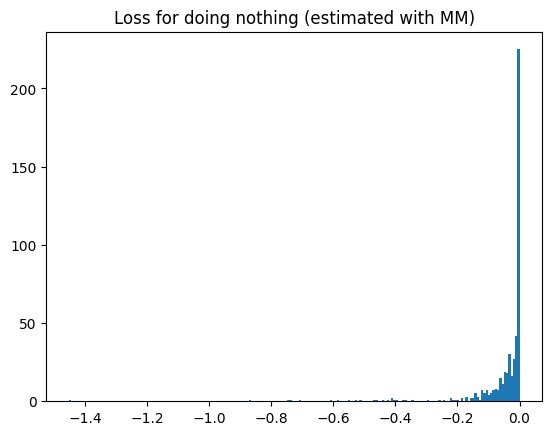

mean -0.053628545615348015
median -0.011524715905468691


In [100]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

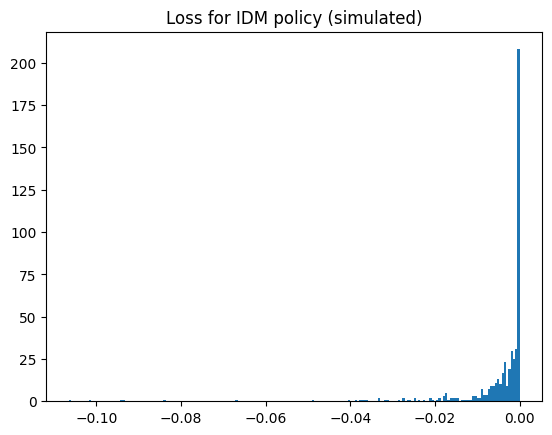

mean -0.005120855363588924
median -0.0012659258577911057


In [41]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

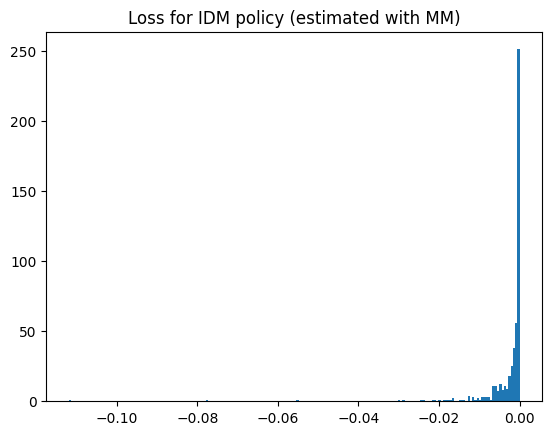

mean -0.002699028017411931
median -0.0005439686094454339


In [42]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

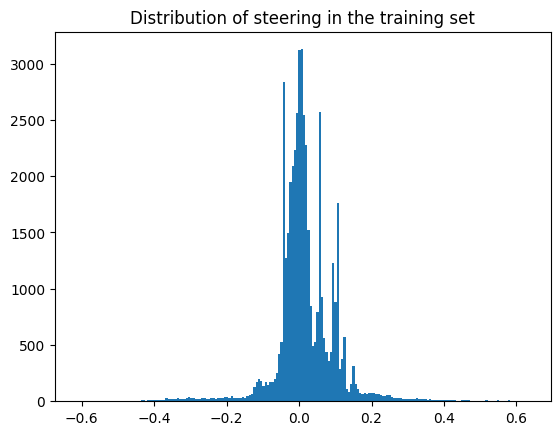

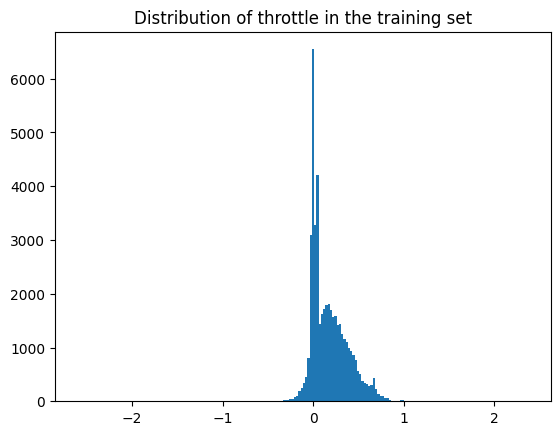

In [94]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

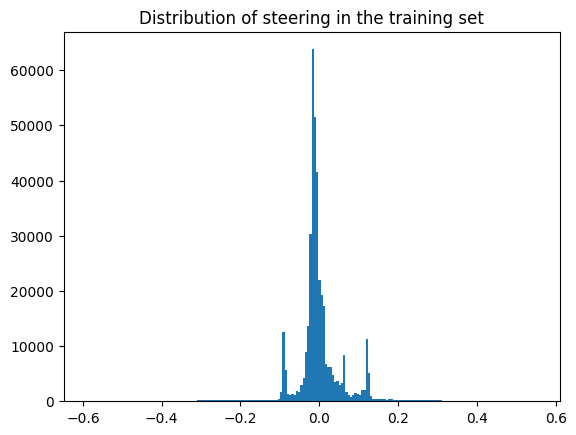

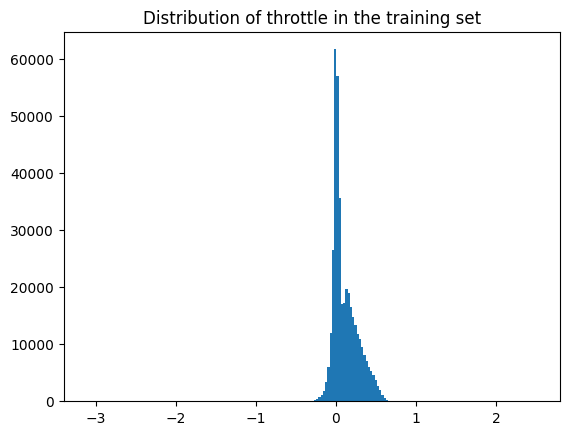

In [39]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()